# 1. Import

In [1]:
# Import
import scipy.io as sio
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

# 2. Data preparation

In [2]:
# Load train and test dataset
# Predictors X_* consist of differential pressures in Pa of 94 time steps.
# There are 2400 training predictors and 1600 testing predictors.
import os
train_mat_file = './IAsignals_train_v2.mat'
test_mat_file = './IASignals_test_predictors.mat'

mat_contents = sio.loadmat(train_mat_file)
Y_train = mat_contents['ClassDATA']
X_train = mat_contents['noisy_SignalDATA']
Y_train2=np.zeros((len(Y_train)))
Y_train2=[i for i in np.argwhere(Y_train==1)[:,1]]


mat_contents = sio.loadmat(test_mat_file)
X_test = mat_contents['noisy_SignalDATA']
Y_test2 = np.random.randint(0, 7, size=(1,X_test.shape[1]))[0]
Y_test = np.zeros((8,X_test.shape[1],))
for i in range(X_test.shape[1]):
        Y_test[Y_test2[i],i]=1


In [3]:
# Normalization of the predictors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.transpose())
X_test = scaler.fit_transform(X_test.transpose())

# 3. Training

In [4]:
# Definition of the KFold, models to train and metrics
kfold = KFold(n_splits=10)

models = [GaussianNB(),
          LogisticRegression(multi_class='ovr'),
          DecisionTreeClassifier(),
          SVC(C=50,kernel='rbf',gamma=1),RandomForestClassifier()]

model_names = ['Naive_Bayes','Logistic_Regression','Decision_Tree','SVC','Random_Forest']
cf_matrix={} # confusion matrix
cv_accurary={} # Accuracy

In [5]:
# We first investigate for the best parameters of a Random Forest
rfc = RandomForestClassifier()
param_grid = {
        'n_estimators' : [200,500],
        'max_features': ['auto','sqrt','log2'],
        'max_depth': [4,5,6],
        'criterion' : ['gini','entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train,Y_train2)
criterion,max_depth,max_features,n_estimators = CV_rfc.best_params_.values()

In [6]:
# Training and scoring of all the models
cf_matrix={}
cv_accuracy={}
for i in range(len(models)):
    if model_names[i]=='Random_Forest':
        model = RandomForestClassifier(criterion=criterion,max_depth=max_depth,max_features=max_features,
                                       n_estimators=n_estimators)
    else:
        model = models[i]
    print(model)
    model.fit(X_train,Y_train2)
    y_pred_test = model.predict(X_test)       
    cf_matrix[model_names[i]] = confusion_matrix(Y_test2,y_pred_test)
    cv_accuracy[model_names[i]] = cross_val_score(model,X_test,Y_test2,
                           cv=kfold,scoring='accuracy')  

GaussianNB()
LogisticRegression(multi_class='ovr')


/Users/mgrani/opt/anaconda3/envs/ml2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mgrani/opt/anaconda3/envs/ml2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

DecisionTreeClassifier()
SVC(C=50, gamma=1)
RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       n_estimators=500)


# 4. Score vizualisation

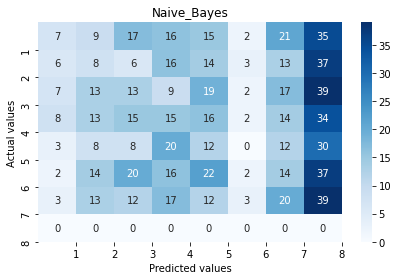

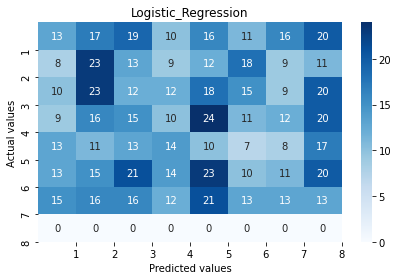

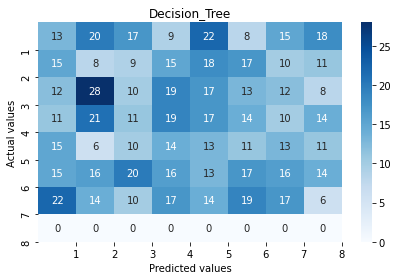

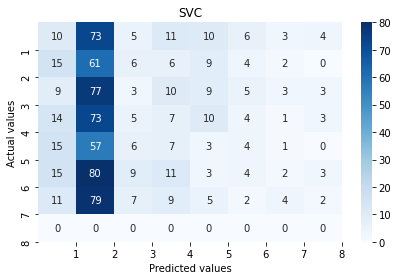

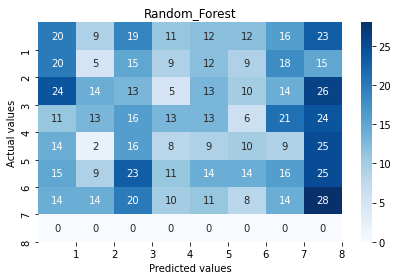

In [7]:
# Visualization of the scores

# Seaborn heatmap
for i in range(len(models)):
    fig = plt.figure()
    ax = sns.heatmap(cf_matrix[model_names[i]],annot=True,cmap='Blues')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Actual values')
    ax.set_xticks(np.arange(1,9,1))
    ax.set_yticks(np.arange(1,9,1))
    ax.xaxis.set_ticklabels(np.arange(1,9,1))
    ax.yaxis.set_ticklabels(np.arange(1,9,1))
    ax.set_title(model_names[i])
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

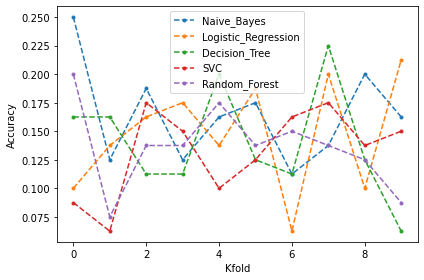

In [8]:
# Accuracies
fig=plt.figure()
pd.DataFrame(cv_accuracy).plot(linestyle='--',marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Kfold')
plt.tight_layout()

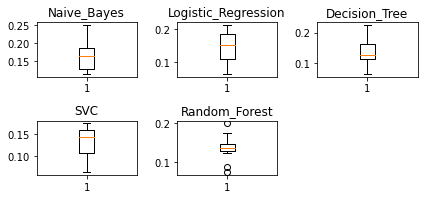

In [9]:
# Box plot of accuracies
for i in range(len(models)):
    ax = plt.subplot(3,3,i+1)
    ax.boxplot(cv_accuracy[model_names[i]])
    ax.set_title(model_names[i])
plt.tight_layout()

# 5. Creating Submission File and Score Evaluation in codalab

In [10]:
# predict using a model. Here we use model 1
y_pred_test = models[1].predict(X_test)
accuracy_score(Y_test2, y_pred_test)

0.11375

In [11]:
# we use pandas here as convienient way to store the submission file. 
# You can also do it without pandas, put please note that the submission file must be zipped containing a file named submission.csv 
# The csv has one column labeled PredictedClass with the labels occuring in the order of the provided test data for the phase

import pandas as pd
df_submit = pd.DataFrame(y_pred_test, columns=["PredictedClass"])
df_submit.to_csv("./submission.zip", sep=";", decimal=".", index=False, compression=dict(method='zip',
                        archive_name='submission.csv') ) 


In [12]:
# now we also write the ground truth file to check everything is ok. Note that the ground_truth file in this notebook is not available, but randomly generated in the third cell above. 
df_gt=pd.DataFrame(Y_test2, columns=["PredictedClass"])
df_gt.to_csv("./gt_fake.csv", sep=";", decimal=".", index=False) 
#we read submission and ground truht 
df_submit2 = pd.read_csv("./submission.zip", sep=";", decimal=".", compression="zip")
df_gt2 = pd.read_csv("./gt_fake.csv", sep=";", decimal=".")
# and calcualte the score. The score must be equally to the score above. This procedure is used in the scoring program in the same way.
accuracy_score(df_submit2.to_numpy()[:,0], df_gt2.to_numpy()[:,0])

0.11375